In [3]:
import pandas as pd
import numpy as np
from datetime import datetime

pd.set_option('display.max_columns', None)

In [6]:
df = pd.read_parquet('../data/processed_encoded/full_valid.parquet.gzip')

In [7]:
df.head()

,Airport_fee,VendorID,improvement_surcharge,DOLocationID,payment_type,LocationID_DO,congestion_surcharge,tip_amount,passenger_count,extra,year_month_day,Zone_PU,Zone_DO,fare_amount,tpep_dropoff_datetime,RatecodeID,mta_tax,total_amount,Average,Maximum,trip_distance,day_of_week,hour_of_day,tolls_amount,LocationID_PU,Minimum,PULocationID,tpep_pickup_datetime,period_of_day_dawn,period_of_day_morning,period_of_day_afternoon,period_of_day_evening
0,0.0,2,1.0,230,2,230,2.5,0.00,1.0,1.0,20240119,West Chelsea/Hudson Yards,Times Sq/Theatre District,12.8,2024-01-19 20:40:19,1.0,0.5,17.80,25.0,29.0,1.87,4,20,0.0,246,21.0,246,2024-01-19 20:28:18,0,0,0,1
1,0.0,2,1.0,68,1,68,2.5,4.00,3.0,0.0,20240113,Union Sq,East Chelsea,11.4,2024-01-13 19:56:50,1.0,0.5,19.40,45.0,55.0,1.04,5,19,0.0,234,35.0,234,2024-01-13 19:44:27,0,0,0,1
2,0.0,1,1.0,107,1,107,2.5,4.80,2.0,3.5,20240112,Clinton East,Gramercy,19.1,2024-01-13 00:06:06,1.0,0.5,28.90,38.5,46.0,3.20,4,23,0.0,48,31.0,48,2024-01-12 23:44:39,0,0,0,1
3,0.0,2,1.0,137,1,137,2.5,3.02,1.0,2.5,20240124,Sutton Place/Turtle Bay North,Kips Bay,8.6,2024-01-24 19:25:17,1.0,0.5,18.12,38.5,42.0,1.04,2,19,0.0,229,35.0,229,2024-01-24 19:18:07,0,0,0,1
4,0.0,2,1.0,236,1,236,2.5,1.96,1.0,0.0,20240124,Upper East Side North,Upper East Side North,5.8,2024-01-24 09:55:05,1.0,0.5,11.76,38.5,42.0,0.65,2,9,0.0,236,35.0,236,2024-01-24 09:51:12,0,1,0,0


# Aggregate by day

In [9]:
def p99(x):
    return x.quantile(0.99)

def p75(x):
    return x.quantile(0.75)

In [10]:
# Need to onehot encode clusters and vendors, to aggregate properly

df_agg = df.groupby('year_month_day').agg({
        'VendorID' : 'count',
        'Maximum' : 'max',
        'Minimum' : 'max',
        'passenger_count' : ['sum', 'count'],
        'day_of_week' : 'max',
        'period_of_day_dawn' : 'sum',
        'period_of_day_morning' : 'sum',
        'period_of_day_afternoon' : 'sum',
        'period_of_day_evening' : 'sum'
    }).reset_index()

In [11]:
df_agg.head()

year_month_day VendorID Maximum Minimum passenger_count        day_of_week  \
                    count     max     max             sum  count         max   
0       20240101     8113    45.0    32.0          9996.0   8113           0   
1       20240102     7625    43.0    26.0         10209.0   7625           1   
2       20240103     8194    45.0    28.0         10802.0   8194           2   
3       20240104    10243    45.0    26.0         13238.0  10243           3   
4       20240105    10261    38.0    21.0         13335.0  10261           4   

  period_of_day_dawn period_of_day_morning period_of_day_afternoon  \
                 sum                   sum                     sum   
0               2989                  1061                    2488   
1                275                  2094                    3031   
2                308                  2221                    3244   
3                300                  2179                    4047   
4                477                  2399                    3892   

  period_of_day_evening  
                    sum  
0                  1575  
1                  2225  
2                  2421  
3                  3717  
4                  3493

In [12]:
df_agg.columns = [f'{col[0]}_{col[1]}' if col[1] != '' else f'{col[0]}' for col in df_agg.columns]

<Axes: >

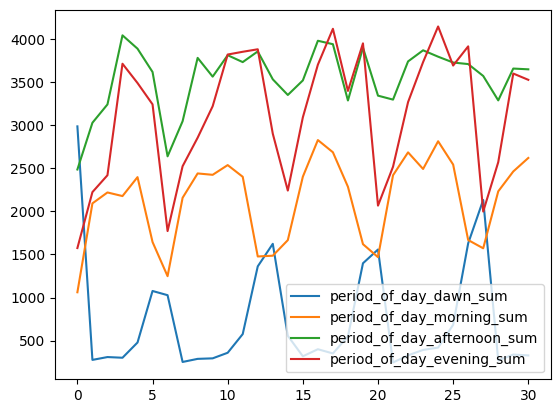

In [15]:
# Maybe cutoff 21/jan and last 5 days
df_agg.sort_values(by='year_month_day')[['period_of_day_dawn_sum', 
                                         'period_of_day_morning_sum', 
                                         'period_of_day_afternoon_sum',
                                         'period_of_day_evening_sum']].plot()

Maybe cutoff 01/jan  
For regression tabular models create features with lag 1 to lag 7, to capture weekly behavior

# Fix Target

In [11]:
df_agg['qty_travels'] = df_agg.qty_travels_today.shift(-1)

In [12]:
df_agg = df_agg.iloc[:-1].reset_index(drop=True)

<Axes: >

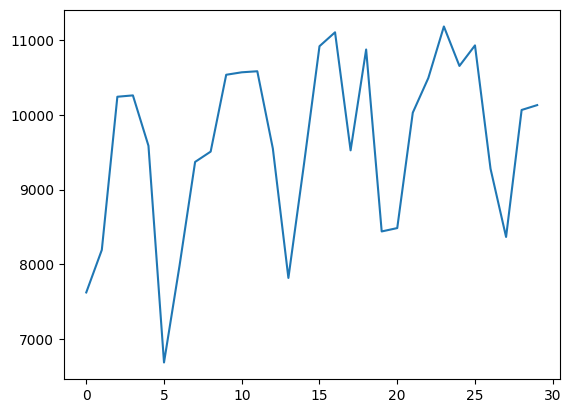

In [13]:
df_agg.qty_travels.plot()

In [14]:
df_agg.head()

,year_month_day,qty_travels_today,max_temperature,min_temperature,passenger_count,day_of_week,period_of_day_dawn,period_of_day_morning,period_of_day_afternoon,period_of_day_evening,qty_travels
0,20240101,8113,45.0,32.0,9996.0,0,2989,1061,2488,1575,7625.0
1,20240102,7625,43.0,26.0,10209.0,1,275,2094,3031,2225,8194.0
2,20240103,8194,45.0,28.0,10802.0,2,308,2221,3244,2421,10243.0
3,20240104,10243,45.0,26.0,13238.0,3,300,2179,4047,3717,10261.0
4,20240105,10261,38.0,21.0,13335.0,4,477,2399,3892,3493,9587.0
